In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2 import Artifact

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.stats import distance, ordination
from skbio.stats.composition import clr

from scipy.cluster import hierarchy
from scipy.spatial import distance

from biom import Table

%matplotlib inline

# Read in Data

In [2]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")

metabo_metadata = metadata.set_index("MetaboSampleID")



## Aqueous

In [3]:
aqueous = pd.read_csv("../metabolome/Aqueous_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T

raw_indexes        = [x for x in list(aqueous.index) if ("Log2(normalized)" not in x)]
normalized_indexes = [x for x in list(aqueous.index) if ("(raw)" not in x)]

raw_aqueous = aqueous.loc[raw_indexes]
log_aqueous = aqueous.loc[normalized_indexes]

raw_aqueous.index = [int(x.split("SBAQ_")[-1][:-5]) if ("SBAQ_" in x)
                     else x 
                     for x in list(raw_aqueous.index)]

log_aqueous.index = [int(x.split("SBAQ_")[-1][:-18]) if ("SBAQ_" in x)
                     else x 
                     for x in list(log_aqueous.index)]

metabo_info_cols = ['Compound Name','Retention Time', 'Measured Retention Time', 
                    'Product Mass','QualifierMass', 'CASNumber', 
                    'CompoundType', 'ISTDCompoundName', 'Mass Column']

raw_aqueous_samples = raw_aqueous.drop(metabo_info_cols).sort_index()
log_aqueous_samples = log_aqueous.drop(metabo_info_cols).sort_index()

## Lipid

In [4]:
lipid = pd.read_csv("../metabolome/Lipid_Green_Tea_compounds_in_Plasma_020722.txt",
                      sep="\t", header=11, index_col="Compound").T
lipid.head()

raw_lipid_indexes =        [x for x in list(lipid.index) if ("Log2(normalized)" not in x)]
normalized_lipid_indexes = [x for x in list(lipid.index) if ("(raw)" not in x)]

raw_lipid = lipid.loc[raw_lipid_indexes]
log_lipid = lipid.loc[normalized_lipid_indexes]

raw_lipid.index = [int(x.split("Lipid_")[-1][:-5]) if ("Lipid_" in x)
                     else x 
                     for x in list(raw_lipid.index)]

log_lipid.index = [int(x.split("Lipid_")[-1][:-18]) if ("Lipid" in x)
                     else x 
                     for x in list(log_lipid.index)]

raw_lipid_samples = raw_lipid.drop(metabo_info_cols).sort_index()
log_lipid_samples = log_lipid.drop(metabo_info_cols).sort_index()

In [5]:
# adding this because index isn't showing up as int type
raw_aqueous_samples.index = [int(x) for x in list(raw_aqueous_samples.index)]
raw_lipid_samples.index = [int(x) for x in list(raw_lipid_samples.index)]

## Microbiome

In [6]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

#tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
#tax = tax.to_dict()["Taxon"]
#microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

In [7]:
microbiome_index_mapper = metadata.set_index("#SampleID")["MetaboSampleID"].to_dict()

new_microbiome_index = [int(microbiome_index_mapper[x]) for x in list(microbiome.index)]
microbiome.index = new_microbiome_index
microbiome = microbiome.sort_index()

# Presence/Absence correlation

## Make presence/absence

In [8]:
def make_presence_absence(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0

In [9]:
presence_aqueous_samples = pd.DataFrame(index = raw_aqueous_samples.index)
presence_lipid_samples = pd.DataFrame(index = raw_lipid_samples.index)
presence_microbiome = pd.DataFrame(index = microbiome.index, columns=microbiome.columns)

for col in raw_aqueous_samples.columns:
    presence_aqueous_samples[col] = raw_aqueous_samples[col].apply(lambda x: make_presence_absence(x, threshold=0.00001))
    
for col in raw_lipid_samples.columns:
    presence_lipid_samples[col] = raw_lipid_samples[col].apply(lambda x: make_presence_absence(x, threshold=0.00001))

for col in microbiome.columns:
    presence_microbiome[col] = microbiome[col].apply(lambda x: -1 * (-x//1)) #ceiling division to convert to presence


## Correlation

In [10]:
from scipy.stats import spearmanr, pearsonr

In [11]:
all_presence = pd.concat([presence_microbiome, presence_aqueous_samples, presence_lipid_samples], axis=1)

In [12]:
all_presence_corr = np.matrix(all_presence.corr(method="spearman"))


In [13]:
microbiome_psuedo = pd.DataFrame(microbiome_mat+0.0001, 
                                 index=microbiome.index, columns=microbiome.columns)
clr_microbiome = pd.DataFrame(clr(microbiome_psuedo), 
                              index=microbiome.index, columns=microbiome.columns)

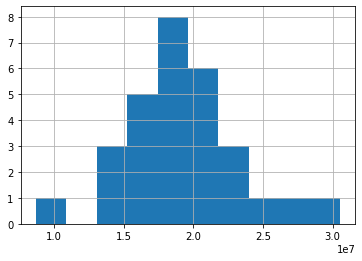

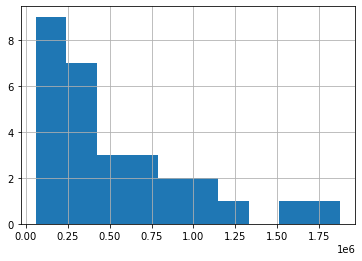

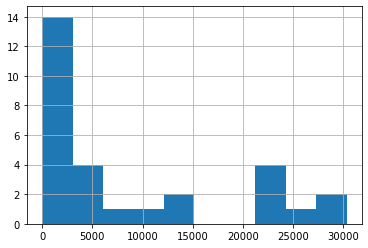

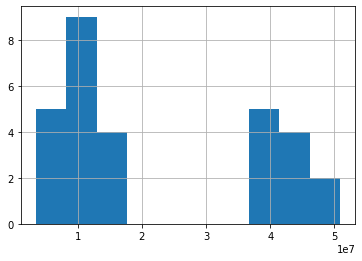

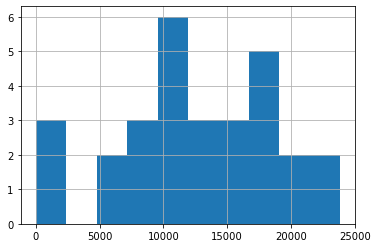

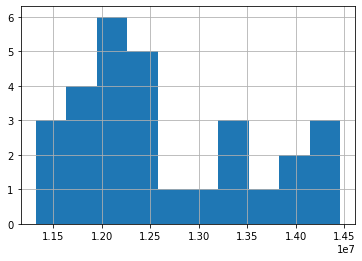

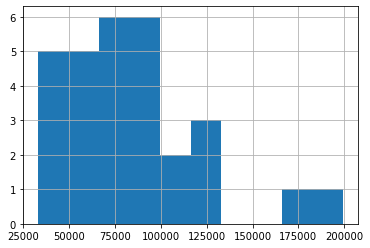

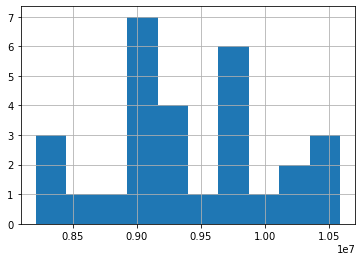

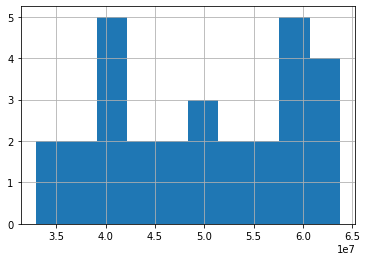

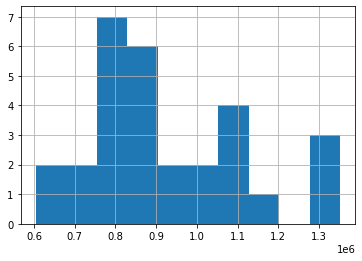

In [14]:
for i in range(10):
    raw_aqueous_samples.iloc[:,i].hist()
    plt.show()

In [15]:
all_data = pd.concat([clr_microbiome, raw_aqueous_samples, raw_lipid_samples], axis=1).apply(pd.to_numeric)

In [16]:
all_pearson = all_data.corr(method="pearson")

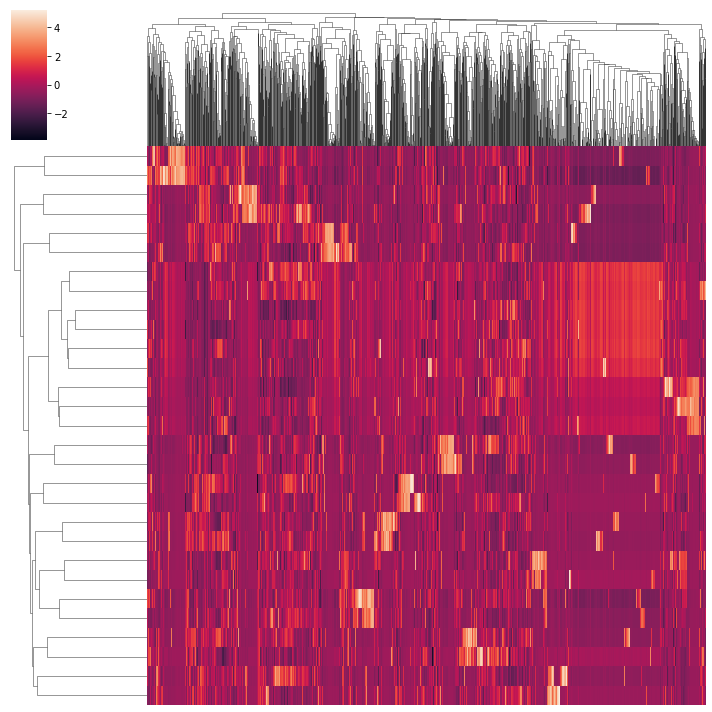

In [17]:
ax = sns.clustermap(all_data, xticklabels=False, yticklabels=False,z_score=1)

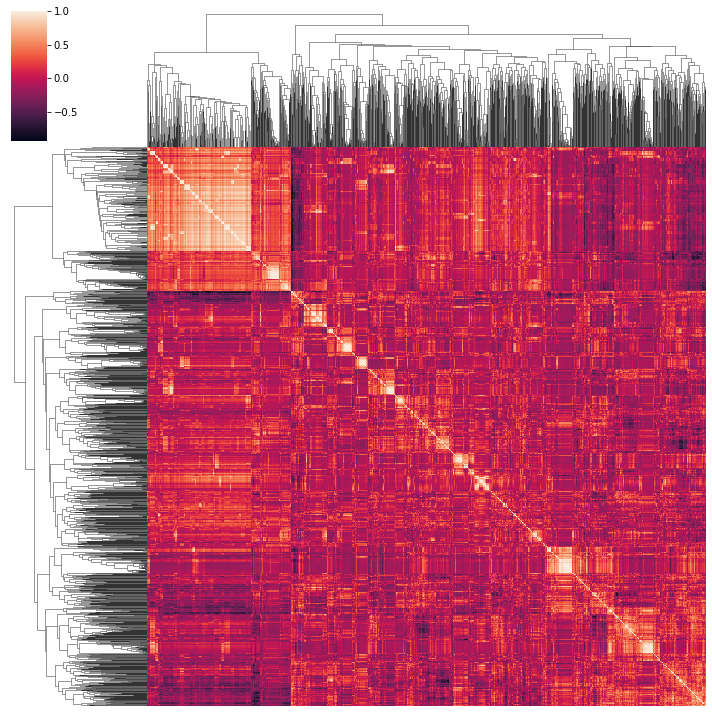

In [18]:
ax = sns.clustermap(all_pearson, xticklabels=False, yticklabels=False)

In [52]:
tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
all_pearson_tax = all_pearson.rename(index=tax, columns=tax)
all_data_tax = all_data.rename(columns=tax)

### Look at strong negative correlations between microbes and compounds

In [60]:
mic_met_corrs = pd.DataFrame(index=microbiome.columns, 
                             columns=list(raw_aqueous_samples.columns) + list(raw_lipid_samples.columns))
mic_met_p = pd.DataFrame(index=microbiome.columns, 
                         columns=list(raw_aqueous_samples.columns) + list(raw_lipid_samples.columns))


for taxa in mic_met_corrs.index:
    for met in mic_met_corrs.columns:
        r,p = pearsonr(all_data[taxa],
                       all_data[met])
        mic_met_corrs.loc[taxa, met] = r
        mic_met_p.loc[taxa, met] = p
        
mic_met_corrs.rename(index=tax, inplace=True)
mic_met_corrs = mic_met_corrs.apply(lambda x: x.astype(float))
mic_met_p.rename(index=tax, inplace=True)
mic_met_p = mic_met_p.apply(lambda x: x.astype(float))

In [83]:
melted_mic_met_corrs = pd.melt(mic_met_corrs.reset_index(), 
                                id_vars="index").rename(columns={"index": "feature 1",
                                                                 "variable": "feature 2",
                                                                 "value": "r"})
melted_mic_met_p = pd.melt(mic_met_p.reset_index(), 
                                id_vars="index").rename(columns={"index": "feature 1",
                                                                 "variable": "feature 2",
                                                                 "value": "p"})

In [84]:
melted_mic_met_corrs.loc[melted_mic_met_corrs["r"] < -0.5]

,feature 1,feature 2,r
3,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,L-ISOLEUCINE**_1.428,-0.551373
10,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,L-ISOLEUCINE**_1.428,-0.568399
65,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,L-ISOLEUCINE**_1.428,-0.506553
593,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,L-ISOLEUCINE**_1.428,-0.524222
703,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,Adenosine_4.092,-0.517573
...,...,...,...
420809,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,PG(17:1(9Z)/12:0)_3.854,-0.675199
420821,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,PG(17:1(9Z)/12:0)_3.854,-0.647245
420962,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,PG(17:1(9Z)/12:0)_3.854,-0.530412
421115,k__Bacteria; p__Proteobacteria; c__Betaproteob...,PG(17:1(9Z)/12:0)_3.854,-0.528729


In [94]:
# Bonferroni significant
melted_mic_met_corrs.loc[melted_mic_met_p["p"] < 0.05/len(melted_mic_met_p.index)]

,feature 1,feature 2,r
9022,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,Betonicine_4.389,0.832425
9049,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,Betonicine_4.389,0.882256
9183,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,Betonicine_4.389,0.878309
9201,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,Betonicine_4.389,0.819176
24636,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,Coumarone_1.827,0.888341
...,...,...,...
416713,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,C1772 - 2.203,0.840355
416719,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,C1772 - 2.203,0.840355
416983,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,C1772 - 2.203,0.876552
418877,k__Bacteria; p__Proteobacteria; c__Betaproteob...,C1788 - 2.23,0.860768


In [133]:
for a, b, r in melted_mic_met_corrs.loc[melted_mic_met_p["p"] < 0.05/len(melted_mic_met_p.index)][["feature 1", "feature 2", "r"]].values:
    print(a)
    print(b)
    print(r)
    print()

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae
Betonicine_4.389
0.8324254284725089

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Clostridium; s__hathewayi
Betonicine_4.389
0.8822561855576316

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Oscillospira; s__
Betonicine_4.389
0.8783092843841779

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae
Betonicine_4.389
0.8191756246127755

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Coprococcus; s__
Coumarone_1.827
0.8883414826364089

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__Clostridium; s__septicum
C2106 - 7.428
0.8994914476243372

k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae; g__SMB53; s__
C2106 - 7.428
0.8255543267211684

k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteria

In [127]:
0.05/42000

1.1904761904761906e-06

In [111]:
melted_mic_met_corrs["features"] = melted_mic_met_corrs["feature 1"].apply(lambda x: x.split("; f__")[-1]) + "     " + melted_mic_met_corrs["feature 2"].apply(lambda x: x.split(" - ")[0].split("_")[0])

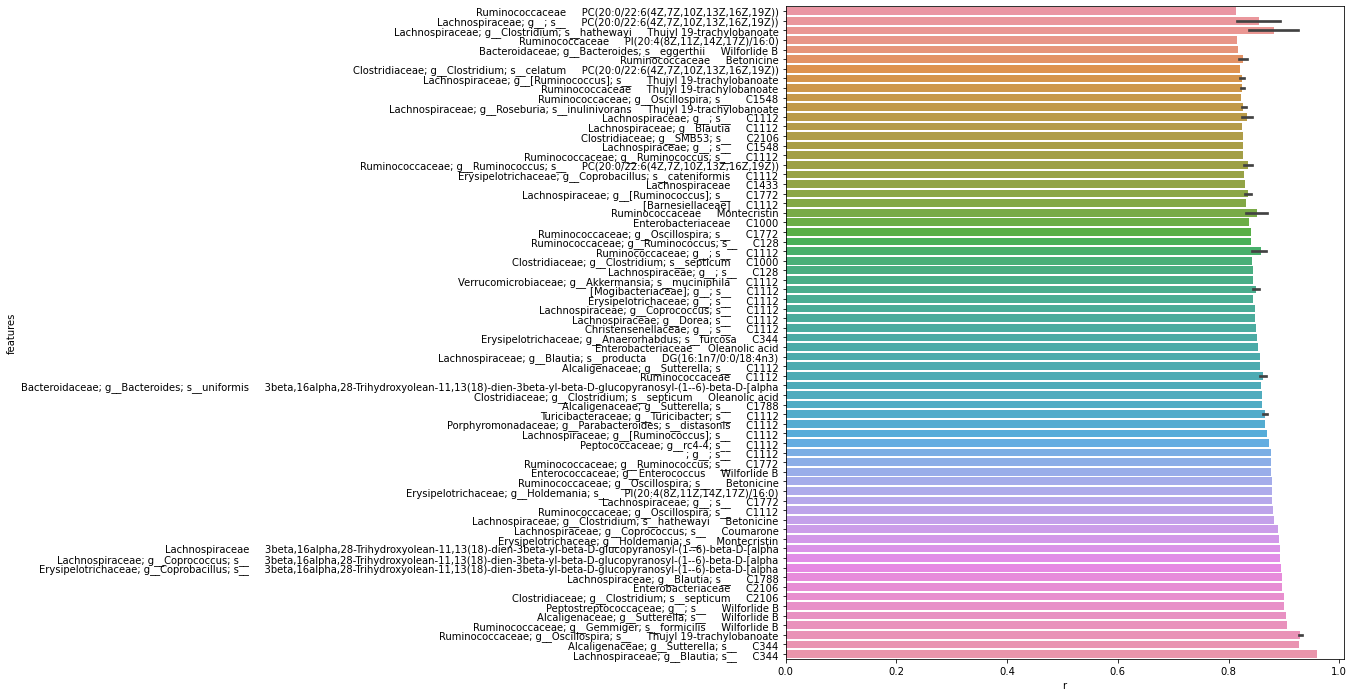

In [112]:
ax = sns.barplot(x="r",y="features",
            data=melted_mic_met_corrs.loc[melted_mic_met_p["p"] < 0.05/len(melted_mic_met_p.index)].sort_values("r"))

plt.gcf().set_size_inches(10,12)

Montecristin is a key metabolite of acetogenins, acetic acid is a major fermentation product by holdemania

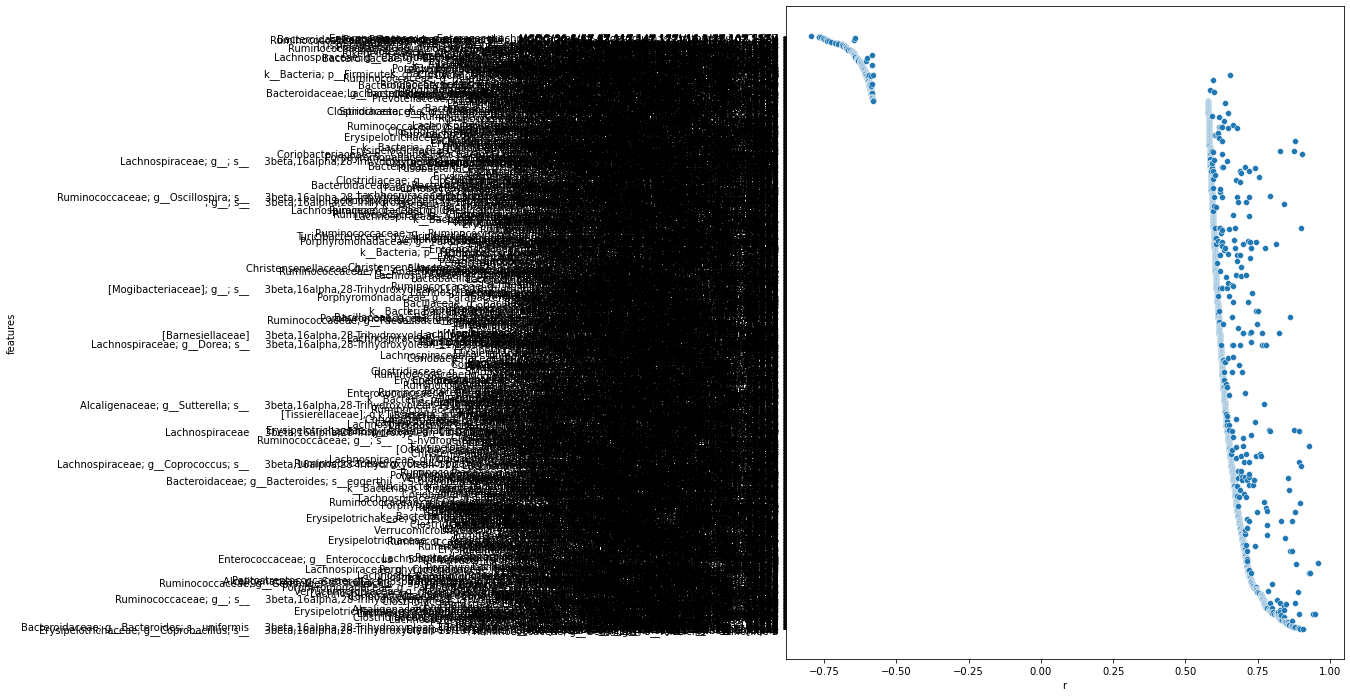

In [121]:
ax = sns.scatterplot(x="r",y="features",
            data=melted_mic_met_corrs.loc[melted_mic_met_p["p"] < 0.001].sort_values("r"))

plt.gcf().set_size_inches(10,12)

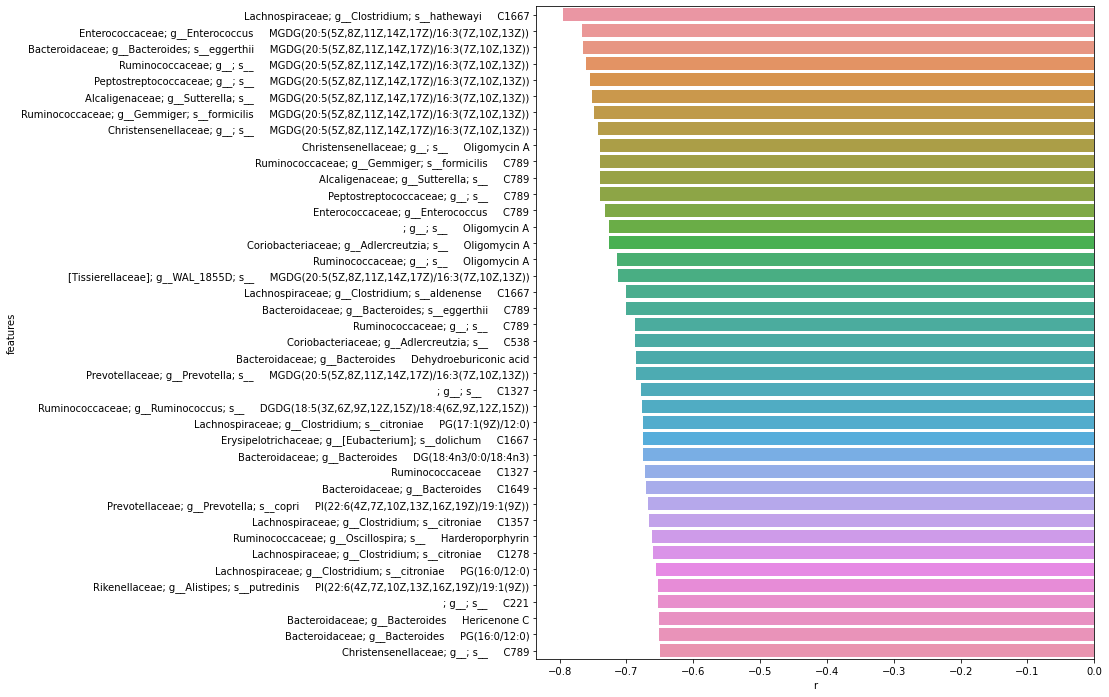

In [124]:
ax = sns.barplot(x="r",y="features",
            data=melted_mic_met_corrs.loc[melted_mic_met_corrs["r"] <= -0.65].sort_values("r"))

plt.gcf().set_size_inches(10,12)

Oligomycin A is a macrolide produced by streptomyces to inhibit other organisms

In [30]:
np.matrix(all_pearson_tax < -0.9).sum()

10

In [34]:
flat_all_pearson_tax = pd.melt(all_pearson_tax.reset_index(), 
                               id_vars="index").rename(columns={"index": "feature 1",
                                                                "variable": "feature 2",
                                                                "value": "r"})

In [36]:
flat_all_pearson_tax.loc[flat_all_pearson_tax["r"] <= -0.85]

,feature 1,feature 2,r
37906,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Proteobacteria; c__Gammaproteo...,-0.875877
65559,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.857646
65658,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.863462
100758,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,-0.857392
120258,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,-0.857392
...,...,...,...
1432431,SLBPA(42:0)_5.858,"PC(22:4(7Z,10Z,13Z,16Z)/16:0)_6.391",-0.888319
1442628,C239 - 6.896,"PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/19:1(9Z))_5.169",-0.875854
1471189,"PC(22:2(13Z,16Z)/14:1(9Z))_5.254",SLBPA(42:0)_5.858,-0.868368
1471228,C239 - 6.896,SLBPA(42:0)_5.858,-0.885947


### distribution of pearson r

In [ ]:
array_of_pearson_corr = all_pearson.to_numpy().flatten()

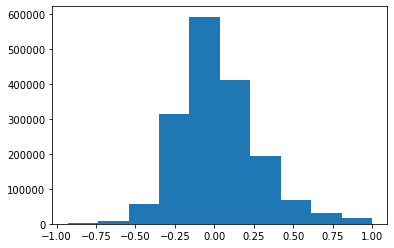

In [358]:
plt.hist(array_of_pearson_corr)
plt.show()

In [359]:
array_of_pearson_corr_noself = array_of_pearson_corr[np.where(array_of_pearson_corr<1)]
for i in np.arange(70,100,5):
    print(f"The {i}th percentile of pearson correlation coefficients is {np.percentile(array_of_pearson_corr_noself, q=i)}")

The 70th percentile of pearson correlation coefficients is 0.12116249991314311
The 75th percentile of pearson correlation coefficients is 0.1615959890365321
The 80th percentile of pearson correlation coefficients is 0.20838684615116138
The 85th percentile of pearson correlation coefficients is 0.26486838735027257
The 90th percentile of pearson correlation coefficients is 0.34133889883326174
The 95th percentile of pearson correlation coefficients is 0.4776059634095738


### Format for SCNIC

In [372]:
# gotta format for SCNIC
scnic_format_corr_mat = np.empty((array_of_pearson_corr_noself.shape[0],3), dtype=object)
index = 0
for i,feature1 in enumerate(all_pearson.columns):
    for j,feature2 in enumerate(all_pearson.columns):
        if i<j:
            scnic_format_corr_mat[index,0] = feature1
            scnic_format_corr_mat[index,1] = feature2
            scnic_format_corr_mat[index,2] = all_pearson.loc[feature1,feature2]
            index+=1

In [382]:
scnic_format_corr_df = pd.DataFrame(scnic_format_corr_mat,
                                    columns=["feature1", "feature2", "r"])
scnic_format_corr_df.dropna(inplace=True)
scnic_format_corr_df.to_csv("../microbiome/all_pearson.tsv", sep="\t", index=False)

In [384]:
all_data.to_csv("../microbiome/all_data.tsv", sep="\t")
all_data.T.to_csv("../microbiome/all_data_transposed.tsv", sep="\t")

In [385]:
!biom convert -i ../microbiome/all_data.tsv -o ../microbiome/all_data.biom --table-type="OTU table" --to-hdf5
!biom convert -i ../microbiome/all_data_transposed.tsv -o ../microbiome/all_data_transposed.biom --table-type="OTU table" --to-hdf5

## SCNIC
**All SCNIC code run in a SCNIC setup environment**

>! SCNIC_analysis.py modules \
-i ../microbiome/all_pearson.tsv \
-o ../microbiome/SCNIC_modules_output/ \
--method naive \
--min_r .35 \
--table ../microbiome/all_data_transposed.biom \
--verbose

>!SCNIC_analysis.py modules \
-i ../microbiome/all_pearson.tsv \
-o ../microbiome/SCNIC_modules_45_output/ \
--method naive \
--min_r .45 \
--table ../microbiome/all_data_transposed.biom \
--verbose

## Network

In [56]:
import networkx as nx

In [444]:
G = nx.read_gml("../microbiome/SCNIC_modules_output/correlation_network.gml")
G.remove_edges_from(nx.selfloop_edges(G))

In [445]:
modules = pd.read_csv("../microbiome/SCNIC_modules_output/modules.txt", header=None, sep="\t", index_col=0)
# only consider modules with >3 members
filt_modules = modules.loc[modules.notna().sum(axis=1)>5]
modules_melted = pd.melt(filt_modules.reset_index(), id_vars=0)
modules_melted.columns = ["module", "IGNORE","taxon"]
modules_melted = modules_melted.set_index("taxon")


modules_melted.rename(index=tax, inplace=True) # map OTUs to taxonomy name

In [446]:
modules_melted.head(10)

,module,IGNORE
taxon,,
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Alcaligenaceae; g__Sutterella; s__,module_0,1
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae,module_1,1
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Alcaligenaceae; g__Sutterella; s__,module_2,1
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Epulopiscium; s__,module_3,1
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales,module_4,1
C159 - 2.574,module_5,1
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae,module_6,1
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__caccae,module_7,1
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__; g__; s__,module_8,1


In [447]:
from matplotlib import cm

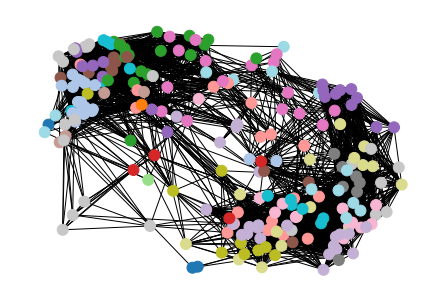

In [448]:
pos = nx.spring_layout(G)

color_list = []
to_remove = []
for node in G:
    if node in modules_melted.index:
        color_list.append(int(modules_melted.loc[node,"module"].split("_")[1]))
    else:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)
        
        
cmap = cm.get_cmap('tab20')

nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)

#for module in filt_modules.index:
#    mod_contents = modules.loc[module].dropna().to_list()
#    avg_x = sum([pos[node][0] for node in mod_contents])/len(mod_contents)
#    avg_y = sum([pos[node][1] for node in mod_contents])/len(mod_contents)
#    plt.annotate(module.split("_")[1],
#                xy=(avg_x,avg_y))

In [391]:
for column in modules.columns:
    modules[column] = modules[column].apply(lambda x: tax[x] if x in tax.keys() else x)

In [392]:
modules.to_csv("../microbiome/SCNIC_modules_output/modules_tax.tsv", sep="\t")

## Network min r=.45

In [449]:
G = nx.read_gml("../microbiome/SCNIC_modules_45_output/correlation_network.gml")
G.remove_edges_from(nx.selfloop_edges(G))

In [450]:
modules = pd.read_csv("../microbiome/SCNIC_modules_45_output/modules.txt", header=None, sep="\t", index_col=0)
# only consider modules with >3 members
filt_modules = modules.loc[modules.notna().sum(axis=1)>5]
modules_melted = pd.melt(filt_modules.reset_index(), id_vars=0)
modules_melted.columns = ["module", "IGNORE","taxon"]
modules_melted = modules_melted.set_index("taxon")

modules_melted.rename(index=tax, inplace=True) # map OTUs to taxonomy name

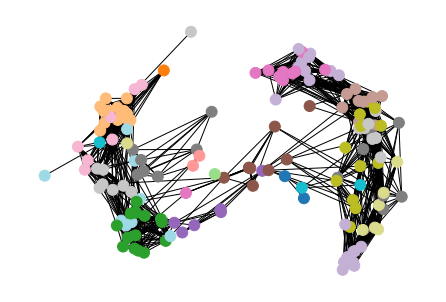

In [451]:
pos = nx.spring_layout(G)

color_list = []
to_remove = []
for node in G:
    if node in modules_melted.index:
        color_list.append(int(modules_melted.loc[node,"module"].split("_")[1]))
    else:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)
        
        
cmap = cm.get_cmap('tab20')

nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)

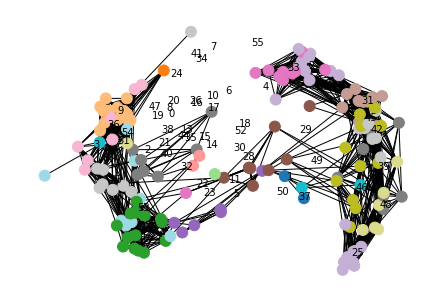

In [452]:
nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)
for module in filt_modules.index:
    mod_contents = modules.loc[module].dropna().to_list()
    avg_x = sum([pos[node][0] for node in mod_contents])/len(mod_contents)
    avg_y = sum([pos[node][1] for node in mod_contents])/len(mod_contents)
    plt.annotate(module.split("_")[1],
                xy=(avg_x,avg_y))

## Cleaning data to maybe deconvolute?

In [396]:
tax_collapsed_microbiome = microbiome
for col in tax_collapsed_microbiome.columns:
    tax_collapsed_microbiome.loc["tax",col] = tax[col]

In [397]:
tax_collapsed_microbiome = tax_collapsed_microbiome.groupby(tax_collapsed_microbiome.loc["tax"], axis=1).sum().drop("tax")

In [398]:
for col in tax_collapsed_microbiome.columns:
    # filter tax with mean rel abundance < 0.001
    if tax_collapsed_microbiome[col].mean() >= 0.001:
        pass
    else:
        tax_collapsed_microbiome.drop(col,axis=1,inplace=True)
    

In [399]:
clr_tax_collapsed_microbiome = pd.DataFrame(clr(np.array(tax_collapsed_microbiome,dtype=float)+0.000001),
                                            index=tax_collapsed_microbiome.index,
                                            columns=tax_collapsed_microbiome.columns)

tax_collapsed_all_data = pd.concat([clr_tax_collapsed_microbiome, raw_aqueous_samples, raw_lipid_samples],axis=1)

In [400]:
tax_collapsed_all_data.T.to_csv("../microbiome/all_data_tax_transposed.tsv", sep="\t")

In [401]:
!biom convert -i ../microbiome/all_data_tax_transposed.tsv -o ../microbiome/all_data_tax_transposed.biom --table-type="OTU table" --to-hdf5

In [402]:
for col in tax_collapsed_all_data.columns:
    tax_collapsed_all_data[col] = tax_collapsed_all_data[col].apply(pd.to_numeric)

In [403]:
tax_collapsed_all_pearson = tax_collapsed_all_data.corr("pearson")

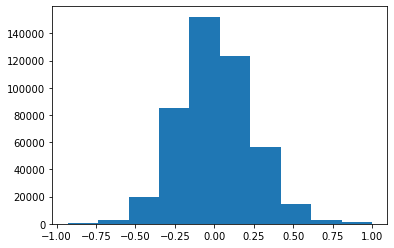

In [404]:
plt.hist(np.array(tax_collapsed_all_pearson).flatten())
plt.show()

In [405]:
tax_collapsed_all_pearson_corr_flat = np.array(tax_collapsed_all_pearson).flatten()
tax_collapsed_all_pearson_corr_flat_noself = tax_collapsed_all_pearson_corr_flat[np.where(tax_collapsed_all_pearson_corr_flat<1)]
for i in np.arange(70,100,5):
    print(f"The {i}th percentile of pearson correlation coefficients is {np.percentile(tax_collapsed_all_pearson_corr_flat_noself, q=i)}")

The 70th percentile of pearson correlation coefficients is 0.11867498762666058
The 75th percentile of pearson correlation coefficients is 0.15428640451953005
The 80th percentile of pearson correlation coefficients is 0.19450763927520953
The 85th percentile of pearson correlation coefficients is 0.24165319197282129
The 90th percentile of pearson correlation coefficients is 0.30190728681716295
The 95th percentile of pearson correlation coefficients is 0.39279907299117944


In [406]:
# gotta format for SCNIC
scnic_format_corr_mat = np.empty((tax_collapsed_all_pearson_corr_flat_noself.shape[0],3), dtype=object)
index = 0
for i,feature1 in enumerate(tax_collapsed_all_pearson.columns):
    for j,feature2 in enumerate(tax_collapsed_all_pearson.columns):
        if i<j:
            scnic_format_corr_mat[index,0] = feature1
            scnic_format_corr_mat[index,1] = feature2
            scnic_format_corr_mat[index,2] = tax_collapsed_all_pearson.loc[feature1,feature2]
            index+=1

In [408]:
tax_collapsed_scnic_format_corr_df = pd.DataFrame(scnic_format_corr_mat,
                                    columns=["feature1", "feature2", "r"])
tax_collapsed_scnic_format_corr_df.dropna(inplace=True)

In [409]:
tax_collapsed_scnic_format_corr_df.to_csv("../microbiome/all_data_tax_corr.tsv", sep="\t", index=False)

>! SCNIC_analysis.py modules \
-i ../microbiome/all_data_tax_corr.tsv \
-o ../microbiome/SCNIC_modules_collapsed_tax_output/ \
--method naive \
--min_r .30 \
--table ../microbiome/all_data_tax_transposed.biom \
--verbose

In [453]:
G = nx.read_gml("../microbiome/SCNIC_modules_collapsed_tax_output/correlation_network.gml")
G.remove_edges_from(nx.selfloop_edges(G))

In [456]:
modules = pd.read_csv("../microbiome/SCNIC_modules_collapsed_tax_output/modules.txt", header=None, sep="\t", index_col=0)
# only consider modules with >3 members
filt_modules = modules.loc[modules.notna().sum(axis=1)>5]
modules_melted = pd.melt(filt_modules.reset_index(), id_vars=0)
modules_melted.columns = ["module", "IGNORE","taxon"]
modules_melted = modules_melted.set_index("taxon")

modules_melted.rename(index=tax, inplace=True) # map OTUs to taxonomy name

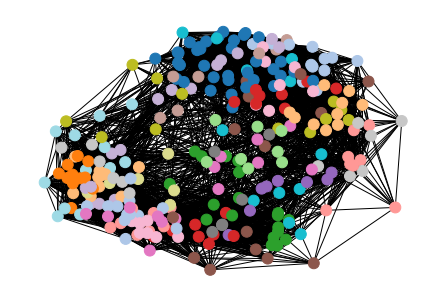

In [457]:
pos = nx.spring_layout(G,)

color_list = []
to_remove = []
for node in G:
    if node in modules_melted.index:
        color_list.append(int(modules_melted.loc[node,"module"].split("_")[1]))
    else:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)
        
        
cmap = cm.get_cmap('tab20')

nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)

>! SCNIC_analysis.py modules \
-i ../microbiome/all_data_tax_corr.tsv \
-o ../microbiome/SCNIC_modules_collapsed_tax_40_output/ \
--method naive \
--min_r .40 \
--table ../microbiome/all_data_tax_transposed.biom \
--verbose

In [459]:
G = nx.read_gml("../microbiome/SCNIC_modules_collapsed_tax_40_output/correlation_network.gml")
G.remove_edges_from(nx.selfloop_edges(G))

modules = pd.read_csv("../microbiome/SCNIC_modules_collapsed_tax_40_output/modules.txt", header=None, sep="\t", index_col=0)
# only consider modules with >3 members
filt_modules = modules.loc[modules.notna().sum(axis=1)>5]
modules_melted = pd.melt(filt_modules.reset_index(), id_vars=0)
modules_melted.columns = ["module", "IGNORE","taxon"]
modules_melted = modules_melted.set_index("taxon")

modules_melted.rename(index=tax, inplace=True) # map OTUs to taxonomy name



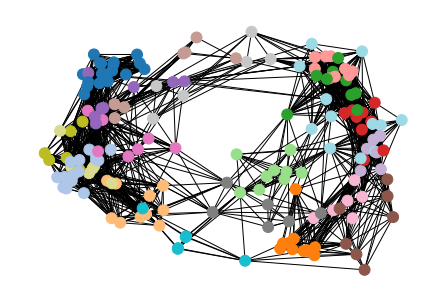

In [460]:
pos = nx.spring_layout(G,)

color_list = []
to_remove = []
for node in G:
    if node in modules_melted.index:
        color_list.append(int(modules_melted.loc[node,"module"].split("_")[1]))
    else:
        to_remove.append(node)

for node in to_remove:
    G.remove_node(node)
        
        
cmap = cm.get_cmap('tab20')

nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)

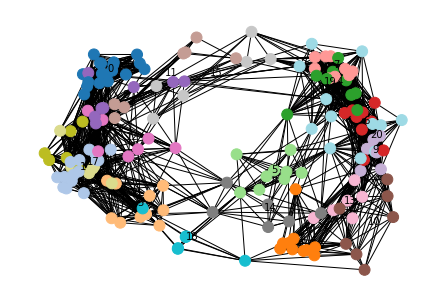

In [461]:
nx.draw(G, pos, cmap=cmap, node_color=color_list, node_size=120)
for module in filt_modules.index:
    mod_contents = modules.loc[module].dropna().to_list()
    avg_x = sum([pos[node][0] for node in mod_contents])/len(mod_contents)
    avg_y = sum([pos[node][1] for node in mod_contents])/len(mod_contents)
    plt.annotate(module.split("_")[1],
                xy=(avg_x,avg_y))

In [471]:
# getting a list of modules on the right vs left side

right_modules = []
left_modules = []
for module in filt_modules.index:
    mod_contents = modules.loc[module].dropna().to_list()
    avg_x = sum([pos[node][0] for node in mod_contents])/len(mod_contents)
    if avg_x > 0:
        print(module, "right")
        right_modules.append(module)
    else:
        print(module, "left")
        left_modules.append(module)
    

module_0 left
module_1 left
module_2 right
module_3 left
module_4 right
module_5 right
module_6 right
module_7 right
module_8 left
module_9 right
module_10 right
module_11 left
module_12 left
module_13 right
module_14 right
module_15 left
module_16 left
module_17 left
module_18 left
module_19 right
module_20 right


In [474]:
filt_modules.loc[right_modules]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,,,,,,,,,,,,,,,,,,
module_2,C98 - 0.846,C674 - 0.846,C11 - 0.839,C58 - 0.846,C161 - 0.838,C223 - 0.846,C15 - 0.838,C2252 - 0.847,C357 - 0.847,C206 - 0.838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_4,C886 - 6.039,Vernoflexuoside_7.4,Enanderinanin G_8.653,Valyl-Tyrosine_6.482,Nigakilactone H_8.243,Taraxinic acid 1'-O-beta-D-glucopyranoside_6.684,Marchantin C_6.778,Taraxacolide 1-O-b-D-glucopyranoside_7.616,Valyl-Hydroxyproline_1.651,Rehmaionoside C_7.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_5,Shikonofuran D_8.462,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,Clitidine_5.347,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,k__Bacteria; p__Proteobacteria; c__Betaproteob...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_6,AS-1 A_3.283,Montecristin_3.277,C839 - 4.736,"PI(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/19:1(9Z))_4.262","PC(22:2(13Z,16Z)/14:1(9Z))_5.254",C1666 - 4.592,"7alpha,21S,25-Trihydroxy-3beta-acetoxy-21S,23R...",C239 - 6.896,C814 - 1.517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_7,C889 - 2.167,C32 - 2.703,C26 - 3.214,Spiramycin_3.716,C1089 - 3.498,C119 - 2.99,C24 - 2.571,PS(P-20:0/16:1(9Z))_3.332,"PC(18:4(6Z,9Z,12Z,15Z)/18:4(6Z,9Z,12Z,15Z))_3.525",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_9,C824 - 5.347,"PI(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/18:1(9Z))_3.931","MGDG(18:2(9Z,12Z)/18:2(9Z,12Z))_5.945",C211 - 5.048,C629 - 4.474,Cohibin D_3.677,C536 - 7.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_10,C222 - 0.954,5-Aminoimidazole ribonucleotide_1.025,gamma-Glutamyl-valine_1.783,Lupinate_1.461,L-aminoadipic acid**_1.48,C1412 - 0.789,C2340 - 0.797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_13,Irisoquin D_3.649,"Stigmasta-4,25-dien-3beta,6beta-diol_4.339",Theonellasterol B_3.888,Methyl 11-oxoasiatate_2.95,Regelin D_3.926,Schleicherastatin 5_3.923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
module_14,Rubescensin C_1.185,PG(P-20:0/0:0)_3.626,C1657 - 4.663,Montecristin_4.032,Montecristin_4.206,"PI(20:4(8Z,11Z,14Z,17Z)/16:0)_3.679",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [478]:
for x in filt_modules.loc["module_5"].to_list():
    print(x)

Shikonofuran D_8.462
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__
Clitidine_5.347
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__[Ruminococcus]; s__
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia; s__
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Parabacteroides; s__distasonis
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Alcaligenaceae; g__Sutterella; s__
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [485]:
dict(G.adj)["Shikonofuran D_8.462"]

AtlasView({'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides': {'r': 0.6985306871836598}, 'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__': {'r': 0.4999572983689105}, 'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Porphyromonadaceae; g__Parabacteroides; s__distasonis': {'r': 0.6959260727022589}, 'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__': {'r': 0.5802389422492688}, 'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Blautia; s__': {'r': 0.5757692990433598}, 'k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__[Ruminococcus]; s__': {'r': 0.6496577615071394}, 'k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Alcaligenaceae; g__Sutterella; s__': {'r': 0.662607456973729}, 'Serratumin A_7.108': {'r': 0.4734873812320638}, 'C

## Collapse at genus level

In [136]:
! qiime taxa collapse \
--i-table ../microbiome/table_GT.qza \
--i-taxonomy ../microbiome/taxonomy_GT.qza \
--p-level 6 \
--o-collapsed-table ../microbiome/L6-collapsed-table.qza

Saved FeatureTable[Frequency] to: ../microbiome/L6-collapsed-table.qza
